# atlas line to adjustable CCFV3 boundaries

In [1]:
# pip install opencv-python
# pip install tqdm

In [2]:
# pip install rdp

In [3]:
# pip install ipympl

In [4]:
# pip install plotly

In [5]:
# pip install ipywidgets>=7.5

In [6]:
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import copy

import plotly.express as px
import plotly.graph_objects as go

from PIL import Image
from skimage.color import rgb2gray
from scipy.io import savemat
from skimage.morphology import skeletonize, remove_small_holes, binary_dilation, binary_opening, binary_closing, area_opening, area_closing
from skimage.measure import label, regionprops
from tqdm import tqdm
from rdp import rdp
from scipy.signal import savgol_filter

sys.path.insert(0, 'D:/merfish_registration_110121')
sys.path.insert(0, 'D:/MerfishAnalysisModule_121721/adjustable_contour_utility')

from distance_trace_edge_extraction import seedSearch, distance_tracing
from angle import angle

# 1. read image

In [7]:

img_dat = Image.open('D:/merfish_registration_110121/slice706.png')
img = np.array(img_dat)


In [8]:
edge_interval=1; # edge resample interval, apply to all_edges_region, all_Edges, all_anchors, and correspondence

# 1-1: read cortical color

In [9]:


file = 'D:/merfish_registration_110121/cortical_color.txt'
my_file = open(file, "r")
content = my_file.read()
content_list = content.split('\n')
my_file.close()

cortical_color_set=set()
for item in content_list:
    item1=item.split('\t')
    item1[0]=int(item1[0])
    item1[1]=int(item1[1])
    item1[2]=int(item1[2])
    cortical_color_set.add(item1[0]*1000000+item1[1]*1000+item1[2])



# 2. get all unique colors represent different regions

In [10]:

row=img.shape[0]
col=img.shape[1]

all_colorVec=[]
color_idx_dict=dict()

for i in range(row):
    for j in range(col):
        colorVec=img[i,j,:]
        all_colorVec.append(colorVec)

unique_regions = np.unique(all_colorVec, axis=0)
unique_regions = unique_regions.tolist()
unique_regions.pop()

for i in range(len(unique_regions)):
    color_idx_dict.update({unique_regions[i][0]*1000000+unique_regions[i][1]*1000+unique_regions[i][2]:unique_regions[i]})

# 3. region index assignment, separate cortical and non-cortical regions, clear small regions

In [11]:

curPlot_colorIdx=np.empty(shape=[row,col])

bw=np.empty(shape=[row,col])
counter=0

# 3-1: put unique color to set use hashing
colorSet=set()
for i in tqdm(range(len(unique_regions))):
    colorSet.add(unique_regions[i][0]*1000000+unique_regions[i][1]*1000+unique_regions[i][2])

# 3-2: label the atlas with color hashs
cortical_idx_list=set()
non_cortical_idx_list=set()
for j1 in tqdm(range(row)):
    for j2 in range(col):
        colorVec=img[j1,j2,:]
        if (colorVec[0]*1000000+colorVec[1]*1000+colorVec[2]) in colorSet and (colorVec[0]*1000000+colorVec[1]*1000+colorVec[2]) in cortical_color_set:
            curPlot_colorIdx[j1][j2]=colorVec[0]*1000000+colorVec[1]*1000+colorVec[2]
            cortical_idx_list.add(colorVec[0]*1000000+colorVec[1]*1000+colorVec[2])
        if (colorVec[0]*1000000+colorVec[1]*1000+colorVec[2]) in colorSet and (colorVec[0]*1000000+colorVec[1]*1000+colorVec[2]) not in cortical_color_set:
            curPlot_colorIdx[j1][j2]=colorVec[0]*1000000+colorVec[1]*1000+colorVec[2]
            non_cortical_idx_list.add(colorVec[0]*1000000+colorVec[1]*1000+colorVec[2])

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:23<00:00, 33.37it/s]


In [12]:

all_edges_region=dict()
all_edges_region_idx=dict()
all_edges_region_idx_rev=dict()

counter=0

# 3-2: get region based edges, cortical area

In [13]:

for curIdx in tqdm(cortical_idx_list):
    curPlot_region=(curPlot_colorIdx==curIdx)
    curPlot_region=binary_opening(curPlot_region)
    curPlot_region=remove_small_holes(curPlot_region)
    curPlot_region=255*(curPlot_region) # convert boolean to int
    
    curPlot_region=np.flip(curPlot_region,0)
    
    edges = cv2.Laplacian(curPlot_region.astype(float),cv2.CV_64F)
    bw1=edges>0
    
    p=regionprops(label(bw1))
    
    # add all contours
    all_curEdge_idx=[]
    for i in range(len(p)):
        
        contoursCur=p[i].coords
        contoursCur=contoursCur.tolist()
        
        # swap i,j to x,y
        for item in contoursCur:
            item[0], item[1] = item[1], item[0]
        
        # use distance tracing to loop the contour: find seed
        seeds=seedSearch(contoursCur)

        # if the contour is a circle then seeds can be empty, insert 0 instead
        if len(seeds)==0:
            seeds=[0]

        contoursCur1=distance_tracing(seeds[0],contoursCur,edge_interval)
        
        #contoursCur1.append(contoursCur1[0])

        if len(contoursCur1[0])>=10:
            all_edges_region.update({counter:contoursCur1[0]})
            all_curEdge_idx.append(counter)
            all_edges_region_idx_rev.update({counter:curIdx})
            counter=counter+1
        
    all_edges_region_idx.update({curIdx:all_curEdge_idx})

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:11<00:00,  6.41it/s]


# 3-3: get region based edges, non-cortical area

In [14]:

for curIdx in tqdm(non_cortical_idx_list):
    curPlot_region=(curPlot_colorIdx==curIdx)
    curPlot_region=binary_opening(curPlot_region)
    curPlot_region=remove_small_holes(curPlot_region)
    curPlot_region=255*(curPlot_region) # convert boolean to int
    
    curPlot_region=np.flip(curPlot_region,0)
    
    edges = cv2.Laplacian(curPlot_region.astype(float),cv2.CV_64F)
    bw1=edges>0
    
    p=regionprops(label(bw1))
    
    # add all contours
            
    all_curEdge_idx=[]
    for i in range(len(p)):
        
        contoursCur=p[i].coords
        contoursCur=contoursCur.tolist()
        
        # swap i,j to x,y
        for item in contoursCur:
            item[0], item[1] = item[1], item[0]
        
        # use distance tracing to loop the contour: find seed
        seeds=seedSearch(contoursCur)

        # if the contour is a circle then seeds can be empty, insert 0 instead
        if len(seeds)==0:
            seeds=[0]
        
        contoursCur1=distance_tracing(seeds[0],contoursCur,edge_interval)
        
        #contoursCur1.append(contoursCur1[0])

            
        if len(contoursCur1[0])>=10:
            all_edges_region.update({counter:contoursCur1[0]})
            all_curEdge_idx.append(counter)
            all_edges_region_idx_rev.update({counter:curIdx})
            counter=counter+1
        
    all_edges_region_idx.update({curIdx:all_curEdge_idx})

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:27<00:00,  3.46it/s]


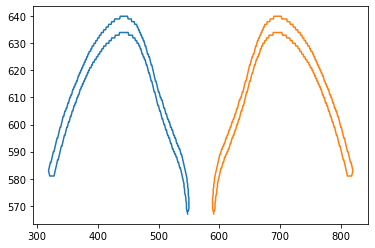

In [15]:
curIdx=11*1000000+12*1000+13
curPlot_region=(curPlot_colorIdx==curIdx)
curPlot_region=binary_opening(curPlot_region)
curPlot_region=remove_small_holes(curPlot_region)
curPlot_region=255*(curPlot_region) # convert boolean to int

curPlot_region=np.flip(curPlot_region,0)

edges = cv2.Laplacian(curPlot_region.astype(float),cv2.CV_64F)
bw1=edges>0

p=regionprops(label(bw1))

for i in range(len(p)):
        
    contoursCur=p[i].coords
    contoursCur=contoursCur.tolist()

    # swap i,j to x,y
    for item in contoursCur:
        item[0], item[1] = item[1], item[0]
    
    
    
    seeds=seedSearch(contoursCur)

    # if the contour is a circle then seeds can be empty, insert 0 instead
    if len(seeds)==0:
        seeds=[0]

    contoursCur1=distance_tracing(seeds[0],contoursCur,edge_interval)

    x=[contoursCur1[0][i][0] for i in range(len(contoursCur1[0]))]
    y=[contoursCur1[0][i][1] for i in range(len(contoursCur1[0]))]

    plt.plot(x,y)

plt.show()

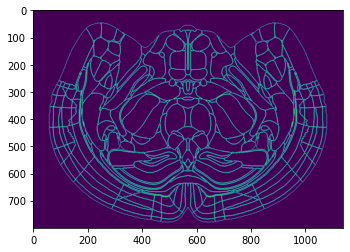

In [16]:
curEdgePlot=np.empty(shape=[row,col])

for key, value in all_edges_region.items():
    curEdge=value
    for j in range(len(curEdge)):
        curEdgePlot[curEdge[j][1],curEdge[j][0]]=255
        
# fig=px.imshow(curEdgePlot)
# fig.show()
plt.imshow(curEdgePlot)
plt.imsave("D:/merfish_registration_110121/testEdgesNew_cortical.tiff", curEdgePlot)

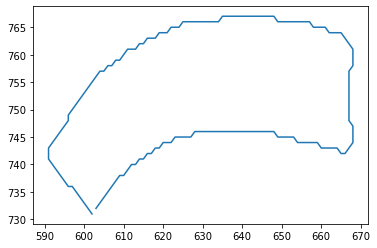

In [17]:
len(all_edges_region)
curEdge=all_edges_region.get(1)
x=[curEdge[i][0] for i in range(len(curEdge))]
y=[curEdge[i][1] for i in range(len(curEdge))]

plt.plot(x,y)
plt.savefig("D:/merfish_registration_110121/single_region_Edge.tiff")

# 5-1: relabel the edge atlas (with 2-pixel wide edges) so that the 2-pixel wide edges will be assigned with unique index

In [18]:

# generate edge matrix
curEdgePlot=np.empty(shape=[row,col])

for key, value in all_edges_region.items():
    curEdge=value
    for j in range(len(curEdge)):
        curEdgePlot[curEdge[j][1],curEdge[j][0]]=key+1 # key start with 0, remember to adjust back

# generate single edge matrix
img_gray=rgb2gray(img)
edges_detected = cv2.Laplacian(img_gray,cv2.CV_64F)
bw=edges_detected>0
bw=np.flip(bw,0)

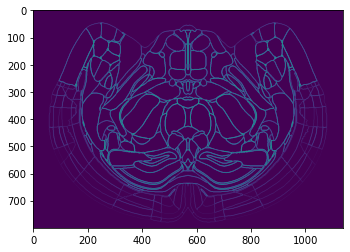

In [19]:
plt.imshow(curEdgePlot)
savemat("D:/merfish_registration_110121/test_labeled_edge_123121.mat", {"bw":bw})
savemat("D:/merfish_registration_110121/test_labeled_edge_curEdgePlot_123121.mat", {"curEdgePlot":curEdgePlot})

# 5-1-1: relabeling process

In [20]:

edge_dict = dict()
edge_dict_rev=dict()
edge_idx_use=1
curEdgePlot_Labeled=np.empty(shape=[row,col])
bw_reLabeled=np.empty(shape=[row,col])

for i in range(5,bw.shape[0]-5):
    for j in range(5,bw.shape[1]-5):
        
        if bw[i][j]>0:
            
            # check if current point's neighbors are empty (isolated pt)
            sumPt=0;
            for u in range(-1,2):
                for v in range(-1,2):
                    sumPt=sumPt+int(bw[i+u][j+v]>0)
            
            if sumPt<3:
                continue
                        
            idx_temp=[int(curEdgePlot[i-1,j-1]),int(curEdgePlot[i+1,j+1]),int(curEdgePlot[i+1,j-1]),int(curEdgePlot[i-1,j+1]),int(curEdgePlot[i+1,j]),int(curEdgePlot[i-1,j]),int(curEdgePlot[i,j+1]),int(curEdgePlot[i,j-1])]
            idx_temp=np.unique(idx_temp)
            idx_temp=np.delete(idx_temp,0,None)
            cur_edge=0;
            
            if str(idx_temp-1) not in edge_dict.keys():
                edge_dict.update({str(idx_temp-1):edge_idx_use})
                edge_dict_rev.update({edge_idx_use:idx_temp-1})
                cur_edge=edge_idx_use;
                edge_idx_use=edge_idx_use+1;
            else:
                cur_edge=edge_dict.get(str(idx_temp-1))
            
            for k1 in range(-1,2):
                for k2 in range(-1,2):
                    if curEdgePlot[i+k1][j+k2]>0:
                        curEdgePlot_Labeled[i+k1][j+k2]=cur_edge
            
            bw_reLabeled[i][j]=cur_edge
        

# 5-1-2: construct a region edge coordination finder

In [21]:



all_edges_region_RegionIdxSearch=dict() # coor: [regionkey,unifiedEdgeIdx,region_edge_posi]
unifiedIdx_regionEdgeSearch=dict()

for key, value in all_edges_region.items():
    for i in range(len(value)):
        unifiedEdgeIdx=curEdgePlot_Labeled[value[i][1]][value[i][0]]
        all_edges_region_RegionIdxSearch.update({str(value[i]):[key,unifiedEdgeIdx,i]}) # [current edge idx, position in current edge]


In [22]:
# now the pipeline is established: we can get the edges for both the regions and single edges, modified single edges and roughly 
# align single edges with region edges, generate the final modified atlas

## however the process need refinement. 
# 1. refine the alignment: is there a way to better determine the points besides calculating the distance between single edge and 
# region edge (which have duplicates and errors)

# 2. refine the edge modification: the intersection modification is not fixed yet. maybe utilize region based edges for help?

# 3. refine calculation time

# 5-2: separate unique edges

# 5-2-1: edges to dict

In [23]:

edges_finder=dict()
for i in range(bw_reLabeled.shape[0]):
    for j in range(bw_reLabeled.shape[1]):
        if bw_reLabeled[i][j]>0:
            cur_edge=edges_finder.get(bw_reLabeled[i][j])
            if cur_edge==None:
                cur_edge=[]
                cur_edge.append([i,j])
            else:
                cur_edge.append([i,j])
            
            edges_finder.update({bw_reLabeled[i][j]:cur_edge})

print('finish putting edges to dict')

finish putting edges to dict


In [24]:
len(edges_finder)

2172

# 5-2-2: separate unique edges

In [25]:

all_edges=dict();
all_edges_seed=dict();

for key, value in tqdm(edges_finder.items()): 
    
    # put all edges to a img
    cur_edge_plot=np.zeros(shape=bw_reLabeled.shape,dtype=np.uint8)
    for i in range(len(value)):
        cur_edge_plot[value[i][0]][value[i][1]]=255
    
    #detect contours in image
    p=regionprops(label(cur_edge_plot))
    
    # add all contours
    all_cur_edges=[];
    all_cur_seeds=[];
    for i in range(len(p)):
        
        contoursCur=p[i].coords
        contoursCur=contoursCur.tolist()
        
        # swap i,j to x,y
        for item in contoursCur:
            item[0], item[1] = item[1], item[0]
        
        # use distance tracing to loop the contour: find seed
        seeds=seedSearch(contoursCur)

        # if the contour is a circle then seeds can be empty, insert 0 instead
        if len(seeds)==0:
            seeds=[0]
        
        contoursCur1=distance_tracing(seeds[0],contoursCur,edge_interval)
        if len(contoursCur1[0])>=5:
            all_cur_edges.append(contoursCur1[0])
            all_cur_seeds.append(seeds[0])
    #print(contours)
    
    if len(all_cur_edges)>0:    
        all_edges.update({key:all_cur_edges})
        all_edges_seed.update({key:all_cur_seeds})

100%|██████████████████████████████████████████████████████████████████████████████| 2172/2172 [00:23<00:00, 90.55it/s]


# 5-2-3: all_edges ---- all_edges_region correspondence

In [26]:

# this time, all_edges have one2one key:edge correspondence due to our curEdgePlot design
        
for key, value in tqdm(all_edges.items()): # key: unified edge idx, value: edge coor
    
    region_edges_idx=edge_dict_rev.get(key)
    
    all_curEdges_region_dict=dict()

    for i in range(len(region_edges_idx)):
        
        curEdge=all_edges_region.get(region_edges_idx[i])
        curEdge_selectedIdx=[]
        
        for k1 in range(len(value[0])):
            dis2regionEdge=[]
            for k in range(len(curEdge)):
                dis2regionEdge.append(math.sqrt((value[0][k1][0]-curEdge[k][0])**2+(value[0][k1][1]-curEdge[k][1])**2))

            curIdx=dis2regionEdge.index(min(dis2regionEdge))
            
            curEdge_selectedIdx.append(curIdx) 
        
        all_curEdges_region_dict.update({region_edges_idx[i]:curEdge_selectedIdx})
    
    unifiedIdx_regionEdgeSearch.update({key:all_curEdges_region_dict})

100%|████████████████████████████████████████████████████████████████████████████████| 989/989 [00:21<00:00, 46.48it/s]


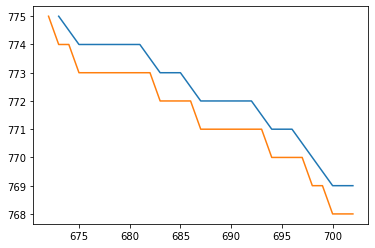

In [27]:
# illustrate 
value=all_edges.get(key)
region_edges_idx=edge_dict_rev.get(key)
curEdge=all_edges_region.get(region_edges_idx[0])

curEdge_selectedIdx=unifiedIdx_regionEdgeSearch.get(key)
curEdge_selectedIdx=curEdge_selectedIdx.get(region_edges_idx[0])

x=[curEdge[i][0] for i in curEdge_selectedIdx]
y=[curEdge[i][1] for i in curEdge_selectedIdx]

plt.plot(x,y)

x1=[value[0][i][0] for i in range(len(value[0]))]
y1=[value[0][i][1] for i in range(len(value[0]))]

plt.plot(x1,y1)

curEdge=all_edges_region.get(region_edges_idx[0])


plt.show()

# 5-3: construct a all_edges_idxSearch for quick search idxs using coor

In [28]:

all_edges_posSearch=dict()
for key, value in all_edges.items():
    for i in range(len(value)):
        for j in range(len(value[i])):
            all_edges_posSearch.update({str(value[i][j]):[str(i)+" "+str(j)]})

# 6. anchor assignment, each anchor should be regarded as a class contains its coor, its line assignment, and its neighbors

In [29]:

class Anchor:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.lines=set()
        self.neighbors=dict() # the var for instantces should be placed in _init_ or it will act similar to java static var?

# 6-1. for each edge, calculate anchors independently.

In [30]:


all_anchors=[]

for key, value in all_edges.items():
    #archors=[]
    for i in range(len(value)):   
        
        interval=30
        
        # case 1: line length <= interval, only add anchors at two end
        if len(value[i])<=interval:
            a1=Anchor(value[i][0][0],value[i][0][1])
            a2=Anchor(value[i][len(value[i])-1][0],value[i][len(value[i])-1][1])
            a1.lines.add(key)
            a2.lines.add(key)
            a1.neighbors.update({key:[a2]})
            a2.neighbors.update({key:[a1]})
            
            all_anchors.append(a1)
            all_anchors.append(a2)
            
        # case 2: line length >40 every anchor points with interval of math.min(40,len[value[i]]/math.ceil(len[value[i]]/40)), include begin and end
        # it as interval
        if len(value[i])>interval:  
            interval=min([interval,int(len(value[i])/math.ceil(len(value[i])/interval))])
            a=[]
            
            # add anchors
            for j in range(0,len(value[i])-1,interval):
                a.append(Anchor(value[i][j][0],value[i][j][1]))
            a.append(Anchor(value[i][len(value[i])-1][0],value[i][len(value[i])-1][1]))
            
            # anchors add neghbors, line correspondence
            for j in range(len(a)):
                at=a[j]
                if j==0:
                    at.neighbors.update({key:[a[j+1]]})
                elif j==len(a)-1:
                    at.neighbors.update({key:[a[j-1]]})
                else:
                    at.neighbors.update({key:[a[j-1],a[j+1]]})
                
                at.lines.add(key)
                a[j]=at # if reference by val this is not needed
                
            # add to all anchors
            for j in range(len(a)):
                all_anchors.append(a[j])

# 6-2. merge very close anchors that actually represent the same anchor

In [31]:


del_idx=set()

for i in range(len(all_anchors)):
    if i not in del_idx:
        at=all_anchors[i]
        for j in range(len(all_anchors)):
            at1=all_anchors[j]
            # for all points on the same line, their interval should be >=5, so line assignment collsion won't happen
            if j != i and math.sqrt((at.x-at1.x)**2+(at.y-at1.y)**2)<=2: # only neighborhood points
                #at.x=int((at.x+at1.x)/2) # these will make edge search impossible
                #at.y=int((at.y+at1.y)/2)
                at.x=int(at.x)
                at.y=int(at.y)
                at.neighbors.update(at1.neighbors) # at1's neighbors all the nei points that is on the same line with at1
                at.lines=set.union(at.lines,at1.lines)
                all_anchors[i]=at # if reference by val this is not needed

                del_idx.add(j)

all_anchors_dedup=[all_anchors[j] for j in range(len(all_anchors)) if j not in del_idx]

# all_anchors_dedup: formulate a set for quick reference by mouse click
all_anchors_dict=dict()
for i in range(len(all_anchors_dedup)):
    all_anchors_dict.update({"["+str(int(all_anchors_dedup[i].x))+", "+str(int(all_anchors_dedup[i].y))+"]":all_anchors_dedup[i]})

In [32]:
all_anchors_dedup=all_anchors
all_anchors_dict=dict()
for i in range(len(all_anchors_dedup)):
    all_anchors_dict.update({"["+str(int(all_anchors_dedup[i].x))+", "+str(int(all_anchors_dedup[i].y))+"]":all_anchors_dedup[i]})

In [33]:
import pyglet
from pyglet.window import key
from pyglet.window import mouse
from pyglet import shapes
from pyglet import text
from pyglet import image
from pyglet import sprite

In [34]:
batch = pyglet.graphics.Batch()

ball_image = pyglet.image.load('D:/merfish_registration_110121/example_merfish_data_icpRegistered_resized.tif')
xv=20
yv=20
pic_sprite=pyglet.sprite.Sprite(ball_image,x=xv,y=xv)

# utility variables
items=[]
labels=[]
selectedEdge=[None];
selectedPt=[None];
modifiedEdge=set();

C:\Users\xulab\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


#  7. drawing utility

In [35]:
GUI_line_search=dict()
GUI_anchor_search=dict()

# add lines
counter=0;
for key, value in all_edges.items():
    for i in range(len(value)):
        curCounterList=[];
        for j in range(len(value[i])-1):
            items.append(shapes.Line(value[i][j][0], value[i][j][1], value[i][j+1][0], value[i][j+1][1], width=3,batch=batch,color=[0,150,200])) 
            curCounterList.append(counter)
            counter=counter+1
        GUI_line_search.update({str([key,i]):curCounterList})
            

# add anchors
for key, value in all_anchors_dict.items():
    items.append(shapes.Rectangle(value.x-4, value.y-4, 8, 8, batch=batch,color=[60,220,50]))  
    GUI_anchor_search.update({"["+str(value.x)+", "+str(value.y)+"]":counter})
    counter=counter+1

# text labels for debug purpose
for key, value in all_edges.items():
    for i in range(len(value)):
        if(len(value[i])<=40):
            labels.append(text.Label(str([len(value[i])]), font_size=10,x=value[i][0][0], y=value[i][0][1]))   

In [36]:
window = pyglet.window.Window(width=1140, height=800)

In [37]:

@window.event
def on_mouse_press(x, y, button, modifiers):
    if button == mouse.LEFT:
        
        selectedEdge[0]=None
        selectedPt[0]=None
        print([x,y])
        for i in range(0,82):
            anchorCur=all_anchors_dict.get("["+str(x+int(i/10)-4)+", "+str(y+int(i%10)-4)+"]")
            
            if anchorCur!=None:
                selectedEdge[0]=copy.deepcopy(anchorCur.lines)
                selectedPt[0]=anchorCur
                print("get edges: "+str(selectedEdge[0]))
                break
            
                
        
@window.event
def on_mouse_drag(x, y, dx, dy, buttons, modifiers):
    # if on archor pt, 
    if selectedEdge[0]!=None:
        
        # -1. get the modified anchor
        selectedEdge[0]=copy.deepcopy(selectedPt[0].lines)
        selectedPt_1=[selectedPt[0].x,selectedPt[0].y]
        selectedPt_1[0]=int(selectedPt_1[0]+dx)
        selectedPt_1[1]=int(selectedPt_1[1]+dy)
                
        print("start drag")  
        # 0. loop all possible edges the anchor connected to
        while len(selectedEdge[0])>0:
            
            curEdgeIdx=selectedEdge[0].pop()
            print(curEdgeIdx)
            curEdge=all_edges.get(curEdgeIdx)
            archorPts=selectedPt[0].neighbors.get(curEdgeIdx)
            
            all_edges_pt_idx=all_edges_posSearch.get(str([selectedPt[0].x,selectedPt[0].y]))
            all_edges_pt_idx_1=int(all_edges_pt_idx[0][2:])
            curEdgeSelect=int(all_edges_pt_idx[0][0])
            
            # 1. loop all possible neighborhood points on this edge, update the whole curEdge
            for i in range(len(archorPts)):
                print("all_edges_anchors_idx: "+str(archorPts[i].x)+","+str(archorPts[i].y)+" "+str(selectedPt_1[0])+","+str(selectedPt_1[1]))

                neighbor_archor1_1=[archorPts[i].x,archorPts[i].y]
                print("test1-2")

                print("neighbor_archor1_1: "+str(neighbor_archor1_1))
                all_edges_nArchor1_idx=all_edges_posSearch.get(str([archorPts[i].x,archorPts[i].y]))
                all_edges_nArchor1_idx_1=int(all_edges_nArchor1_idx[0][2:])               

                print("test1-3")

                pt1=min([all_edges_nArchor1_idx_1,all_edges_pt_idx_1])
                pt2=max([all_edges_nArchor1_idx_1,all_edges_pt_idx_1])

                pts=[neighbor_archor1_1,selectedPt_1]
                pts_idx=[all_edges_nArchor1_idx_1,all_edges_pt_idx_1]
                pt1_val=pts[pts_idx.index(pt1)]
                pt2_val=pts[pts_idx.index(pt2)]

                xCur=pt1_val[0]

                print(pt1_val)
                print(pt2_val)
                for i in range(pt1+1,pt2):
                    if float(selectedPt_1[0])-float(neighbor_archor1_1[0])!=0:
                        # 1. slope update
                        a=(float(selectedPt_1[1])-float(neighbor_archor1_1[1]))/(float(selectedPt_1[0])-float(neighbor_archor1_1[0]))
                        b=float(neighbor_archor1_1[1])-a*float(neighbor_archor1_1[0])

                        # 2. value range update, scale the x coor for each pt
                        new_x_interval=(pt2_val[0]-pt1_val[0])/(pt2-pt1)

                        # 3. update pts according to new x and y
                        curPt=curEdge[curEdgeSelect][i]

                        xCur=xCur+new_x_interval
                        curPt[0]=int(xCur)
                        curPt[1]=int(a*xCur+b)
                        curEdge[curEdgeSelect][i]=curPt 
                    else:
                        curPt=curEdge[curEdgeSelect][i]
                        curPt[1]=selectedPt_1[1]
                        curEdge[curEdgeSelect][i]=curPt 

                curEdge[curEdgeSelect][pt1]=pt1_val
                curEdge[curEdgeSelect][pt2]=pt2_val
                print("test1-5")
                
            all_edges.pop(curEdgeIdx)
            all_edges.update({curEdgeIdx:curEdge})
            modifiedEdge.add(curEdgeIdx)
            print("test1-6")   
            print("curEdge update finished")
            
            # 2. update graphic components
            print(str([curEdgeIdx,curEdgeSelect]))
            pygletLineRange=GUI_line_search.get(str([curEdgeIdx,curEdgeSelect]))
            for j in range(len(pygletLineRange)):
                lineIdx1=pygletLineRange[j]
                items.pop(lineIdx1)
                items.insert(lineIdx1,shapes.Line(curEdge[curEdgeSelect][j][0], curEdge[curEdgeSelect][j][1], curEdge[curEdgeSelect][j+1][0], curEdge[curEdgeSelect][j+1][1], width=3,batch=batch,color=[0,150,200]))
            print("test2-1")
                
            
            anchorIdx1=GUI_anchor_search.get(str([selectedPt[0].x,selectedPt[0].y]))
            items.pop(anchorIdx1);
            items.insert(anchorIdx1,shapes.Rectangle(selectedPt_1[0]-4, selectedPt_1[1]-4, 8, 8, batch=batch,color=[60,220,50]))
            print("test2-2")

            # 3. update selectedPt releted components
            all_anchors_dict.pop(str([selectedPt[0].x,selectedPt[0].y]))
            all_edges_posSearch.pop(str([selectedPt[0].x,selectedPt[0].y]))  
            print("test2-3")
            
            selectedPt[0].x=selectedPt_1[0]
            selectedPt[0].y=selectedPt_1[1]
            
            all_anchors_dict.update({str([selectedPt[0].x,selectedPt[0].y]):selectedPt[0]})
            print([selectedPt[0].x,selectedPt[0].y])
            all_edges_posSearch.update({str([selectedPt[0].x,selectedPt[0].y]):all_edges_pt_idx})
            
            GUI_anchor_search.update({str([selectedPt[0].x,selectedPt[0].y]):anchorIdx1})
            print("test2-4")
 
            on_draw()

In [38]:
def on_key_press(symbol, modifiers):

    if symbol == key.ENTER:
        print('The enter key was pressed.')
        window.close()
        pyglet.app.exit()

In [39]:
@window.event
def on_draw():
    window.clear()
    pic_sprite.draw()
    batch.draw()
    #for i in range(len(labels)):
    #    labels[i].draw()
 
    print('Redrawing.')

In [ ]:
pyglet.app.run()

Redrawing.
Redrawing.


# 8: reconstruct atlas based on modified edges

In [ ]:
modifiedEdge

In [ ]:
curEdge=all_edges.get(1782.0)

In [ ]:

# 8-1: modify all_edges_region accordingly
# all_edges are the modified edges
# edge_dict_rev represent the correspondence between all_edges key and all_edges_region key

for key, value in all_edges.items():
    if key in modifiedEdge:
        # find the corresponding region edge idx 
        region_edge_dict=unifiedIdx_regionEdgeSearch.get(key)

        # modify region edges one by one
        for keyCur, valueCur in region_edge_dict.items():
            curEdgeRegion=all_edges_region.get(keyCur)
            
            for i in range(len(valueCur)):
                curEdgeRegion[valueCur[i]]=value[0][i]
            
            if len(curEdgeRegion)>=10:
                
                curEdgeRegionY=[curEdgeRegion[i][1] for i in range(len(curEdgeRegion))]
                winLeng=int(len(curEdgeRegion)/10)
                if winLeng%2==0:
                    winLeng=winLeng+1 # to odd
                    
                curEdgeRegionY=savgol_filter(curEdgeRegionY, winLeng, 1)
                for i in range(len(curEdgeRegion)):
                    curEdgeRegion[i][1]=curEdgeRegionY[i]
                
            all_edges_region.update({keyCur:curEdgeRegion})

In [ ]:

# 8-2: reconstruct atlas
modifiedAtlas=np.ones(shape=img.shape,dtype=np.uint8)*255

for key, value in tqdm(all_edges_region_idx_rev.items()):
    
    colorCur=color_idx_dict.get(value)
    curEdge=all_edges_region.get(key)

    if len(curEdge)>0:
        seeds=seedSearch(curEdge)
        if len(seeds)==0:
            seeds=[0]   
        curEdge=distance_tracing(seeds[0],curEdge,1)
        
        cv2.fillPoly(modifiedAtlas, pts = [np.int32(np.array(curEdge[0]))], color =(colorCur[0],colorCur[1],colorCur[2]))


In [ ]:
plt.imshow(modifiedAtlas)
modifiedAtlas=np.flip(modifiedAtlas,0)
plt.imsave("D:/merfish_registration_110121/reconstructedAtlas.tiff", modifiedAtlas)

In [ ]:
all_edges_region_idx.get(curIdx)

In [ ]:
curEdge=all_edges_region.get(407)
x=[curEdge[i][0] for i in range(len(curEdge))]
y=[curEdge[i][1] for i in range(len(curEdge))]

plt.plot(x,y)

curEdge=all_edges_region.get(408)
x=[curEdge[i][0] for i in range(len(curEdge))]
y=[curEdge[i][1] for i in range(len(curEdge))]

plt.plot(x,y)

plt.show()

In [ ]:
modifiedAtlas=np.ones(shape=img.shape,dtype=np.uint8)*255
    
colorCur=[11,12,13]
curEdge=all_edges_region.get(407)


seeds=seedSearch(curEdge)
if len(seeds)==0:
    seeds=[0]   
curEdge=distance_tracing(seeds[0],curEdge,1)

cv2.fillPoly(modifiedAtlas, pts = [np.int32(np.array(curEdge[0]))], color =(colorCur[0],colorCur[1],colorCur[2]))
plt.imshow(modifiedAtlas)

In [ ]:
x=[curEdge[0][i][0] for i in range(len(curEdge[0]))]
y=[curEdge[0][i][1] for i in range(len(curEdge[0]))]

plt.plot(x,y)

# debug edge modification codes

In [ ]:
dx=10
dy=10
selectedEdge[0]=copy.deepcopy(selectedPt[0].lines)
selectedPt_1=[selectedPt[0].x,selectedPt[0].y]
selectedPt_1[0]=int(selectedPt_1[0]+dx)
selectedPt_1[1]=int(selectedPt_1[1]+dy)

In [ ]:
selectedEdge[0]

In [ ]:
curEdgeIdx=selectedEdge[0].pop()
print(curEdgeIdx)
curEdge=all_edges.get(curEdgeIdx)
archorPts=selectedPt[0].neighbors.get(curEdgeIdx)

all_edges_pt_idx=all_edges_posSearch.get(str([selectedPt[0].x,selectedPt[0].y]))
all_edges_pt_idx_1=int(all_edges_pt_idx)
curEdgeSelect=int(all_edges_pt_idx)
print([all_edges_pt_idx,curEdgeSelect])

In [ ]:
x=[curEdge[i][0] for i in range(0, int(len(curEdge)))]
y=[curEdge[i][1] for i in range(0, int(len(curEdge)))]
plt.plot(x,y)

plt.plot(778,753,'X')

plt.show()

In [ ]:
all_edges_pt_idx=all_edges_posSearch.get(str([selectedPt[0].x,selectedPt[0].y]))
all_edges_pt_idx_1=int(all_edges_pt_idx[0][2:])
curEdgeSelect=int(all_edges_pt_idx[0][0])

In [ ]:
selectedPt_1=[777+10, 753+10]


In [ ]:
len(curEdge[curEdgeSelect])

In [ ]:
len(archorPts)

In [ ]:
curEdge1=copy.deepcopy(curEdge)
# 1. loop all possible neighborhood points on this edge, update the whole curEdge
for i in range(len(archorPts)):
    print("all_edges_anchors_idx: "+str(archorPts[i].x)+","+str(archorPts[i].y)+" "+str(selectedPt_1[0])+","+str(selectedPt_1[1]))

    neighbor_archor1_1=[archorPts[i].x,archorPts[i].y]
    print("test1-2")

    print(neighbor_archor1_1)
    all_edges_nArchor1_idx=all_edges_posSearch.get(str([archorPts[i].x,archorPts[i].y]))
    all_edges_nArchor1_idx_1=int(all_edges_nArchor1_idx[0][2:])               

    print("test1-3")

    pt1=min([all_edges_nArchor1_idx_1,all_edges_pt_idx_1])
    pt2=max([all_edges_nArchor1_idx_1,all_edges_pt_idx_1])
    
    pts=[neighbor_archor1_1,selectedPt_1]
    pts_idx=[all_edges_nArchor1_idx_1,all_edges_pt_idx_1]
    pt1_val=pts[pts_idx.index(pt1)]
    pt2_val=pts[pts_idx.index(pt2)]
    
    xCur=pt1_val[0]
    
    print(pt1_val)
    print(pt2_val)
    for i in range(pt1+1,pt2):
        if float(selectedPt_1[0])-float(neighbor_archor1_1[0])!=0:
            # 1. slope update
            a=(float(selectedPt_1[1])-float(neighbor_archor1_1[1]))/(float(selectedPt_1[0])-float(neighbor_archor1_1[0]))
            b=float(neighbor_archor1_1[1])-a*float(neighbor_archor1_1[0])
            
            # 2. value range update, scale the x coor for each pt
            new_x_interval=(pt2_val[0]-pt1_val[0])/(pt2-pt1)
            
            # 3. update pts according to new x and y
            curPt=curEdge1[curEdgeSelect][i]
            
            xCur=xCur+new_x_interval
            curPt[0]=int(xCur)
            curPt[1]=int(a*xCur+b)
            curEdge1[curEdgeSelect][i]=curPt 
        else:
            curPt=curEdge1[curEdgeSelect][i]
            curPt[1]=selectedPt_1[1]
            curEdge1[curEdgeSelect][i]=curPt 

    curEdge1[curEdgeSelect][pt1]=pt1_val
    curEdge1[curEdgeSelect][pt2]=pt2_val
    print("test1-5")

In [ ]:
[selectedPt[0].x,selectedPt[0].y]

In [ ]:
x=[curEdge1[curEdgeSelect][i][0] for i in range(0, int(len(curEdge1[curEdgeSelect])))]
y=[curEdge1[curEdgeSelect][i][1] for i in range(0, int(len(curEdge1[curEdgeSelect])))]
plt.plot(x,y)

x1=[curEdge[curEdgeSelect][i][0] for i in range(0, int(len(curEdge[curEdgeSelect])))]
y1=[curEdge[curEdgeSelect][i][1] for i in range(0, int(len(curEdge[curEdgeSelect])))]
plt.plot(x1,y1)

plt.plot(curEdge1[curEdgeSelect][35][0],curEdge1[curEdgeSelect][35][1],'h')
plt.plot(787,763,'o')
plt.plot(743,763,'X')

plt.show()

In [ ]:
curEdge

In [ ]:
neighbor_archor1_1=[curEdge1[curEdgeSelect][35][0],curEdge1[curEdgeSelect][35][1]]
a1=(float(selectedPt_1[1])-float(neighbor_archor1_1[1]))/(float(selectedPt_1[0])-float(neighbor_archor1_1[0]))
b1=float(neighbor_archor1_1[1])-a1*float(neighbor_archor1_1[0])

In [ ]:
[a1,b1]

In [ ]:
[a1*float(neighbor_archor1_1[0])+b1,float(neighbor_archor1_1[1])]

In [ ]:
[a1*float(selectedPt_1[0])+b1,float(selectedPt_1[1])]

In [ ]:
[a1*float(curEdge1[curEdgeSelect][47][0])+b1,float(curEdge1[curEdgeSelect][47][1])]

In [ ]:
a2=(float(curEdge1[curEdgeSelect][37][1])-float(neighbor_archor1_1[1]))/(float(curEdge1[curEdgeSelect][37][0])-float(neighbor_archor1_1[0]))
a2